Reference: https://github.com/chuachinhon/practical_nlp/blob/master/notebooks/1.0_speech_sentiment_cch.ipynb

In [276]:
import nltk
from nltk.corpus import PlaintextCorpusReader
import matplotlib as mpl
import pandas as pd
import numpy as np
import re
from transformers import pipeline

In [277]:
# Define the file directory
file_directory = '..\\Dataset\\'

# Read a single file 
with open(file_directory + '2022_eng.txt', 'r', encoding="utf8") as file_to_read:
    df = file_to_read.read()

**Issues**
- Hugging Face pipeline can only deal with max 512 tokens. Our paragraphs are too long and hence, need to convert to sentences for hugging face.

In [11]:
# Convert into dataframes, split by sentences
df = (pd.DataFrame(df.split("\n\n"))).rename(columns={0: "Paras"})

In [12]:
# Pre-processing
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #replace "\n" with " "
    text = re.sub(r"\W", " ", text) #replaces non-word characters like ',' with " "
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text) #removes digits e.g. 16 years >> years
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    return text

df["Clean_Text"] = df['Paras'].map(lambda text: clean_text(text))

**Sentiment Analysis**

In [213]:
corpus = list(df['Clean_Text'].values)

In [214]:
nlp_sentiment = pipeline("sentiment-analysis", model= "distilbert-base-uncased-finetuned-sst-2-english" )  
#using 'sentiment-analysis'same as "text-classification" 

In [1]:
#df["Sentiment"] = nlp_sentiment(corpus)

Running the above quote will result in the error below
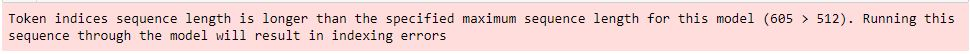

In [ ]:
# Extract pipeline's sentiment analysis output that consists of a label and a score into separate columns
#df['Sentiment_Label'] = [x.get('label') for x in df['Sentiment']]
#df['Sentiment_Score'] = [x.get('score') for x in df['Sentiment']]

### Sentiment Analysis Attempt 2
- Overcoming the issues on max length

In [343]:
# Define the file directory
file_directory = '..\\Dataset\\'

# Read a single file 
with open(file_directory + '2022_eng.txt', 'r', encoding="utf8") as file_to_read:
    df = file_to_read.read()
    
# Convert into dataframes, split by paragraphs
df = (pd.DataFrame(df.split("\n\n"))).rename(columns={0: "Paragraphs"})

#Create new column to store Paragraph Numbers 
df['ParasNo'] = df.index

In [344]:
import numpy as np
from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split('.')))

# calculate lengths of splits using full stops as we are looking for sentences
lens = df['Paragraphs'].str.split('.').map(len)

# create new dataframe, repeating or chaining as appropriate
df = pd.DataFrame({'ParasNo': np.repeat(df['ParasNo'], lens),
                    'Sentences': chainer(df['Paragraphs'])}) 

df.reset_index(inplace=True, drop=True)

In [345]:
# Pre-processing

#Drop rows with empty strings 
df.drop(index=df[df['Sentences'] == ''].index, inplace=True)
df.reset_index(inplace=True, drop=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #replace "\n" with " "
    text = re.sub(r"\W", " ", text) #replaces non-word characters like ',' with " "
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text) #removes digits e.g. 16 years >> years
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    return text

df["Clean_Text"] = df['Sentences'].map(lambda text: clean_text(text))

In [346]:
df.head()

,ParasNo,Sentences,Clean_Text
0,0,My fellow Singaporeans,my fellow singaporeans
1,1,Good evening,good evening
2,2,COVID-19,covid
3,3,We have come a long way in our fight against C...,we have come a long way in our fight against c...
4,3,We are now learning to live with the virus,we are now learning to live with the virus


Sentiment Analysis

In [347]:
corpus = list(df['Clean_Text'].values)

In [348]:
nlp_sentiment = pipeline("sentiment-analysis", model = "distilbert-base-uncased-finetuned-sst-2-english")

In [349]:
%%time
df["Sentiment"] = nlp_sentiment(corpus)

Wall time: 34.4 s


In [350]:
# Extract pipeline's sentiment analysis output that consists of a label and a score into separate columns

df['Sentiment_Label'] = [x.get('label') for x in df['Sentiment']]
df['Sentiment_Score'] = [x.get('score') for x in df['Sentiment']]

In [351]:
df.head()

,ParasNo,Sentences,Clean_Text,Sentiment,Sentiment_Label,Sentiment_Score
0,0,My fellow Singaporeans,my fellow singaporeans,"{'label': 'POSITIVE', 'score': 0.9980775117874...",POSITIVE,0.998078
1,1,Good evening,good evening,"{'label': 'POSITIVE', 'score': 0.9998613595962...",POSITIVE,0.999861
2,2,COVID-19,covid,"{'label': 'POSITIVE', 'score': 0.9856761693954...",POSITIVE,0.985676
3,3,We have come a long way in our fight against C...,we have come a long way in our fight against c...,"{'label': 'POSITIVE', 'score': 0.9546213150024...",POSITIVE,0.954621
4,3,We are now learning to live with the virus,we are now learning to live with the virus,"{'label': 'POSITIVE', 'score': 0.9938626289367...",POSITIVE,0.993863


In [352]:
df['Sentiment_Label'].value_counts()

POSITIVE    335
NEGATIVE    214
Name: Sentiment_Label, dtype: int64

Not sure if the below is alright.
Each sentence has a sentiment label and score. I think that the score tells you how positive or negative it is.
E.g. Sentiment_Label = Positive and Sentiment_Score = 0.957 means it is very very positive ; 
E.g. Sentiment_Label = Negative and Sentiment_Score = 0.788761 means it is very negative.

Basically, if a paragraph has 5 sentences e.g. Paragraph 2, what I am doing is:
1. Calculate how positive each sentence is. This entails:
- Finding out which are the negative sentence 
- Then derive how positive it is
- E.g., Para 2, Sentence 5. Since it is 0.788761 negative, it is 1-0.788.. = 0.21.. positive 

2. Thereafter, I will take the average of the scores to derive how positive of negative a paragraph is.
The existing threshold used is >= 0.5 for positive and <0.5 for negative.

In [353]:
#For illustration - can be removed later on
df[df['ParasNo']==3]

,ParasNo,Sentences,Clean_Text,Sentiment,Sentiment_Label,Sentiment_Score
3,3,We have come a long way in our fight against C...,we have come a long way in our fight against c...,"{'label': 'POSITIVE', 'score': 0.9546213150024...",POSITIVE,0.954621
4,3,We are now learning to live with the virus,we are now learning to live with the virus,"{'label': 'POSITIVE', 'score': 0.9938626289367...",POSITIVE,0.993863
5,3,"With each infection wave, we have managed the...",with each infection wave we have managed the ...,"{'label': 'POSITIVE', 'score': 0.9479452967643...",POSITIVE,0.947945
6,3,"The latest, the Omicron BA",the latest the omicron ba,"{'label': 'POSITIVE', 'score': 0.6443324685096...",POSITIVE,0.644332
7,3,"5 wave, is now subsiding",wave is now subsiding,"{'label': 'NEGATIVE', 'score': 0.7887611389160...",NEGATIVE,0.788761


In [354]:
#Create new column to store scores
df['HF_Score'] = df['Sentiment_Score']

#Update the scores' for rows of negative sentiment by converting it to the negative scale
mask = (df['Sentiment_Label'] == 'NEGATIVE')
df.loc[mask, 'HF_Score'] = - df['Sentiment_Score']

#Take the average of the sentence scores and store in a new dataframe
df_hf = df.groupby(['ParasNo']).mean('HF_Score')
df_hf.drop(columns='Sentiment_Score',axis = 1, inplace=True)

#Assign Sentiment Label for each paragraph where sentiment is positive if score >= 0.50, and negative otherwise. 
df_hf['HF_Label'] = np.where(df_hf['HF_Score']>=0, "POSITIVE","NEGATIVE")
df_hf['HF_Label'].value_counts()

POSITIVE    73
NEGATIVE    32
Name: HF_Label, dtype: int64

In [355]:
df_hf.head()

,HF_Score,HF_Label
ParasNo,,
0,0.998078,POSITIVE
1,0.999861,POSITIVE
2,0.985676,POSITIVE
3,0.550400,POSITIVE
4,-0.885459,NEGATIVE


### Plots

In [356]:
from __future__ import print_function

import ipywidgets as widgets
import matplotlib as mpl
import pandas as pd
import plotly
import plotly_express as px
import plotly.graph_objects as go

mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [357]:
fig = go.Figure(
    data=go.Heatmap(
        z=df_hf["HF_Score"],
        x=df_hf.index,
        y=df_hf["HF_Label"],
        colorscale=px.colors.sequential.RdBu,
    )
)

fig.update_layout(
    title=go.layout.Title(
        text="Sentiment Analysis of NDR 2022"
    ),
    autosize=False,
    width=900,
    height=600,
)

fig.update_layout(yaxis_autorange = "reversed")

fig.show()

VADER
Reference: https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664

In [358]:
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [359]:
# Define the file directory
file_directory = '..\\Dataset\\'

# Read a single file 
with open(file_directory + '2022_eng.txt', 'r', encoding="utf8") as file_to_read:
    df_v = file_to_read.read()
    
# Convert into dataframes, split by paragraphs
df_v = (pd.DataFrame(df_v.split("\n\n"))).rename(columns={0: "Paragraphs"})

#Create new column to store Paragraph Numbers 
df_v['ParasNo'] = df_v.index

In [360]:
# Pre-processing
#Drop rows with empty strings 
df_v.drop(index=df_v[df_v['Paragraphs'] == ''].index, inplace=True)
df_v.reset_index(inplace=True, drop=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #replace "\n" with " "
    text = re.sub(r"\W", " ", text) #replaces non-word characters like ',' with " "
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text) #removes digits e.g. 16 years >> years
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    return text

df_v["Clean_Text"] = df_v['Paragraphs'].map(lambda text: clean_text(text))

In [361]:
df_v.head()

,Paragraphs,ParasNo,Clean_Text
0,My fellow Singaporeans,0,my fellow singaporeans
1,Good evening.,1,good evening
2,COVID-19,2,covid
3,We have come a long way in our fight against C...,3,we have come a long way in our fight against c...
4,"In many other countries, when a wave happens, ...",4,in many other countries when a wave happens ...


In [362]:
df_v['scores'] = df_v['Clean_Text'].apply(lambda x: sid.polarity_scores(x))
df_v.head()

,Paragraphs,ParasNo,Clean_Text,scores
0,My fellow Singaporeans,0,my fellow singaporeans,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,Good evening.,1,good evening,"{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp..."
2,COVID-19,2,covid,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,We have come a long way in our fight against C...,3,we have come a long way in our fight against c...,"{'neg': 0.063, 'neu': 0.867, 'pos': 0.07, 'com..."
4,"In many other countries, when a wave happens, ...",4,in many other countries when a wave happens ...,"{'neg': 0.153, 'neu': 0.694, 'pos': 0.152, 'co..."


In [363]:
#Separate out the compound score
df_v['VADER_Score']  = df_v['scores'].apply(lambda score_dict: score_dict['compound'])
#Assign polarity (pos, neg based on compound score)
df_v['VADER_Label'] = df_v['VADER_Score'].apply(lambda c: 'POSITIVE' if c >=0 else 'NEGATIVE') #(lambda c: 'pos' if c >0 else 'neg' if c<0 else 'neu')

df_v.head() 

,Paragraphs,ParasNo,Clean_Text,scores,VADER_Score,VADER_Label
0,My fellow Singaporeans,0,my fellow singaporeans,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,POSITIVE
1,Good evening.,1,good evening,"{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp...",0.4404,POSITIVE
2,COVID-19,2,covid,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,POSITIVE
3,We have come a long way in our fight against C...,3,we have come a long way in our fight against c...,"{'neg': 0.063, 'neu': 0.867, 'pos': 0.07, 'com...",0.0772,POSITIVE
4,"In many other countries, when a wave happens, ...",4,in many other countries when a wave happens ...,"{'neg': 0.153, 'neu': 0.694, 'pos': 0.152, 'co...",-0.2732,NEGATIVE


In [364]:
from __future__ import print_function

import ipywidgets as widgets
import matplotlib as mpl
import pandas as pd
import plotly
import plotly_express as px
import plotly.graph_objects as go

mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [365]:
fig = go.Figure(
    data=go.Heatmap(
        z=df_v['VADER_Score'],
        x=df_v.index,
        y=df_v["VADER_Label"],
        colorscale=px.colors.sequential.RdBu,
    )
)

fig.update_layout(
    title=go.layout.Title(
        text="Sentiment Analysis of NDR 2022"
    ),
    autosize=False,
    width=900,
    height=600,
)

fig.update_layout(yaxis_autorange = "reversed")

fig.show()

Comparison

In [366]:
df_compare_2022 = pd.merge(df_v[['ParasNo','Paragraphs', 'VADER_Score', 'VADER_Label']], df_hf, how='inner', on='ParasNo')

In [367]:
df_compare_2022['Difference'] = np.where(df_compare_2022["HF_Label"]!=df_compare_2022['VADER_Label'],'Opposing','Same')
df_compare_2022['Difference'].value_counts()

Same        75
Opposing    30
Name: Difference, dtype: int64

There are 30 paragraphs with opposing labels. 
To select 5 for comparison, we selected out paragraphs where each algorithm gave a relatively higher score (>0.30) in the respective labelled polarity.

In [368]:
df_compare_2022[(df_compare_2022['Difference'] == 'Opposing') & (abs(df_compare_2022['HF_Score']) >0.30) & (abs(df_compare_2022['VADER_Score']) >0.30)]

,ParasNo,Paragraphs,VADER_Score,VADER_Label,HF_Score,HF_Label,Difference
5,5,"Thus far, we have had fewer than 1,600 COVID-1...",0.5106,POSITIVE,-0.498362,NEGATIVE,Opposing
12,12,"With our situation stabilising, we will reduce...",0.3898,POSITIVE,-0.410867,NEGATIVE,Opposing
25,25,The basic reality is that international econom...,0.6690,POSITIVE,-0.444158,NEGATIVE,Opposing
26,26,We do not have much influence over this global...,0.5945,POSITIVE,-0.337353,NEGATIVE,Opposing
35,35,Even as we navigate through an uncertain and t...,-0.6369,NEGATIVE,0.796876,POSITIVE,Opposing
44,44,Singaporeans still have differing views on whe...,0.6517,POSITIVE,-0.582289,NEGATIVE,Opposing
47,47,"But at the same time, most Singaporeans do not...",0.7945,POSITIVE,-0.909494,NEGATIVE,Opposing
51,51,"However, as the law stands, this definition of...",0.6597,POSITIVE,-0.625398,NEGATIVE,Opposing
60,60,While we deal with sensitive issues like s377A...,0.6908,POSITIVE,-0.525415,NEGATIVE,Opposing


In [369]:
#Randomly selecting 5 paragraphs to review
import random
random.seed(68)
random.sample(list(df_compare_2022[(df_compare_2022['Difference'] == 'Opposing') & (abs(df_compare_2022['HF_Score']) >0.30) & (abs(df_compare_2022['VADER_Score']) >0.30)].ParasNo),k=5)

[51, 12, 35, 47, 60]

### Year 2012

#### Hugging Face

In [303]:
# Define the file directory
file_directory = '..\\Dataset\\'

# Read a single file 
with open(file_directory + '2012_eng.txt', 'r', encoding="utf8") as file_to_read:
    df = file_to_read.read()
    
# Convert into dataframes, split by paragraphs
df = (pd.DataFrame(df.split("\n\n"))).rename(columns={0: "Paragraphs"})

#Create new column to store Paragraph Numbers 
df['ParasNo'] = df.index

In [304]:
import numpy as np
from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split('.')))

# calculate lengths of splits using full stops as we are looking for sentences
lens = df['Paragraphs'].str.split('.').map(len)

# create new dataframe, repeating or chaining as appropriate
df = pd.DataFrame({'ParasNo': np.repeat(df['ParasNo'], lens),
                    'Sentences': chainer(df['Paragraphs'])}) 

df.reset_index(inplace=True, drop=True)

In [305]:
# Pre-processing

#Drop rows with empty strings 
df.drop(index=df[df['Sentences'] == ''].index, inplace=True)
df.reset_index(inplace=True, drop=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #replace "\n" with " "
    text = re.sub(r"\W", " ", text) #replaces non-word characters like ',' with " "
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text) #removes digits e.g. 16 years >> years
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    return text

df["Clean_Text"] = df['Sentences'].map(lambda text: clean_text(text))

In [306]:
corpus = list(df['Clean_Text'].values)

In [307]:
nlp_sentiment = pipeline("sentiment-analysis", model = "distilbert-base-uncased-finetuned-sst-2-english")

In [308]:
%%time
df["Sentiment"] = nlp_sentiment(corpus)

Wall time: 31.7 s


In [309]:
# Extract pipeline's sentiment analysis output that consists of a label and a score into separate columns

df['Sentiment_Label'] = [x.get('label') for x in df['Sentiment']]
df['Sentiment_Score'] = [x.get('score') for x in df['Sentiment']]

In [310]:
df['Sentiment_Label'].value_counts()

POSITIVE    372
NEGATIVE    233
Name: Sentiment_Label, dtype: int64

In [311]:
#Create new column to store scores
df['HF_Score'] = df['Sentiment_Score']

#Update the scores' for rows of negative sentiment by converting it to the negative scale
mask = (df['Sentiment_Label'] == 'NEGATIVE')
df.loc[mask, 'HF_Score'] = - df['Sentiment_Score']

#Take the average of the sentence scores and store in a new dataframe
df_hf = df.groupby(['ParasNo']).mean('HF_Score')
df_hf.drop(columns='Sentiment_Score',axis = 1, inplace=True)

#Assign Sentiment Label for each paragraph where sentiment is positive if score >= 0.50, and negative otherwise. 
df_hf['HF_Label'] = np.where(df_hf['HF_Score']>=0, "POSITIVE","NEGATIVE")
df_hf['HF_Label'].value_counts()

POSITIVE    38
NEGATIVE    13
Name: HF_Label, dtype: int64

#### VADER

In [312]:
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [313]:
# Define the file directory
file_directory = '..\\Dataset\\'

# Read a single file 
with open(file_directory + '2012_eng.txt', 'r', encoding="utf8") as file_to_read:
    df_v = file_to_read.read()
    
# Convert into dataframes, split by paragraphs
df_v = (pd.DataFrame(df_v.split("\n\n"))).rename(columns={0: "Paragraphs"})

#Create new column to store Paragraph Numbers 
df_v['ParasNo'] = df_v.index

In [314]:
# Pre-processing
#Drop rows with empty strings 
df_v.drop(index=df_v[df_v['Paragraphs'] == ''].index, inplace=True)
df_v.reset_index(inplace=True, drop=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #replace "\n" with " "
    text = re.sub(r"\W", " ", text) #replaces non-word characters like ',' with " "
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text) #removes digits e.g. 16 years >> years
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    return text

df_v["Clean_Text"] = df_v['Paragraphs'].map(lambda text: clean_text(text))

In [315]:
df_v['scores'] = df_v['Clean_Text'].apply(lambda x: sid.polarity_scores(x))
df_v.head()

,Paragraphs,ParasNo,Clean_Text,scores
0,Friends and fellow Singaporeans,0,friends and fellow singaporeans,"{'neg': 0.0, 'neu': 0.492, 'pos': 0.508, 'comp..."
1,We have travelled from Third World to First. Y...,1,we have travelled from third world to first y...,"{'neg': 0.0, 'neu': 0.911, 'pos': 0.089, 'comp..."
2,The next 20 years will see many changes in the...,2,the next years will see many changes in the wo...,"{'neg': 0.044, 'neu': 0.777, 'pos': 0.179, 'co..."
3,We are both a country and a city. So when we l...,3,we are both a country and a city so when we l...,"{'neg': 0.034, 'neu': 0.777, 'pos': 0.189, 'co..."
4,One of the big changes in the world which will...,4,one of the big changes in the world which will...,"{'neg': 0.08, 'neu': 0.874, 'pos': 0.047, 'com..."


In [316]:
#Separate out the compound score
df_v['VADER_Score']  = df_v['scores'].apply(lambda score_dict: score_dict['compound'])
#Assign polarity (pos, neg based on compound score)
df_v['VADER_Label'] = df_v['VADER_Score'].apply(lambda c: 'POSITIVE' if c >=0 else 'NEGATIVE') #(lambda c: 'pos' if c >0 else 'neg' if c<0 else 'neu')

df_v.head() 

,Paragraphs,ParasNo,Clean_Text,scores,VADER_Score,VADER_Label
0,Friends and fellow Singaporeans,0,friends and fellow singaporeans,"{'neg': 0.0, 'neu': 0.492, 'pos': 0.508, 'comp...",0.4767,POSITIVE
1,We have travelled from Third World to First. Y...,1,we have travelled from third world to first y...,"{'neg': 0.0, 'neu': 0.911, 'pos': 0.089, 'comp...",0.3400,POSITIVE
2,The next 20 years will see many changes in the...,2,the next years will see many changes in the wo...,"{'neg': 0.044, 'neu': 0.777, 'pos': 0.179, 'co...",0.9237,POSITIVE
3,We are both a country and a city. So when we l...,3,we are both a country and a city so when we l...,"{'neg': 0.034, 'neu': 0.777, 'pos': 0.189, 'co...",0.9945,POSITIVE
4,One of the big changes in the world which will...,4,one of the big changes in the world which will...,"{'neg': 0.08, 'neu': 0.874, 'pos': 0.047, 'com...",-0.6560,NEGATIVE


#### 2012 Comparison

In [317]:
df_compare_2012 = pd.merge(df_v[['ParasNo','Paragraphs', 'VADER_Score', 'VADER_Label']], df_hf, how='inner', on='ParasNo')

In [318]:
df_compare_2012['Difference'] = np.where(df_compare_2012["HF_Label"]!=df_compare_2012['VADER_Label'],'Opposing','Same')
df_compare_2012['Difference'].value_counts()

Same        41
Opposing    10
Name: Difference, dtype: int64

In [319]:
df_compare_2012[df_compare_2012['Difference'] == 'Opposing']

,ParasNo,Paragraphs,VADER_Score,VADER_Label,HF_Score,HF_Label,Difference
5,5,"In 1992, the Internet had not yet come to Sing...",0.8047,POSITIVE,-0.034608,NEGATIVE,Opposing
8,8,How will these technological advances affect u...,0.1779,POSITIVE,-0.284489,NEGATIVE,Opposing
11,11,So what should the next chapter of the Singapo...,0.4404,POSITIVE,-0.977439,NEGATIVE,Opposing
14,14,"We have done it in this generation, for this g...",0.9918,POSITIVE,-0.115473,NEGATIVE,Opposing
27,27,The transformation will take some time but I a...,0.9838,POSITIVE,-0.108692,NEGATIVE,Opposing
30,30,"If you look ahead, the state is bound to spend...",0.9445,POSITIVE,-0.123764,NEGATIVE,Opposing
31,31,The second message is that social safety nets ...,0.7578,POSITIVE,-0.435775,NEGATIVE,Opposing
35,35,But I would be less than honest if I did not t...,0.4273,POSITIVE,-0.198967,NEGATIVE,Opposing
40,40,Many Singaporeans have explained their conside...,0.9321,POSITIVE,-0.069751,NEGATIVE,Opposing
42,42,"So first work-life balance, I think we need to...",0.9143,POSITIVE,-0.016124,NEGATIVE,Opposing


There are 10 paragraphs with opposing labels. We randomly selected 5 for comparison. 
Note: There are no paragraphs with each algo giving very different scores.

In [321]:
df_compare_2012[(df_compare_2012['Difference'] == 'Opposing') & (abs(df_compare_2012['HF_Score']) >0.30) & (abs(df_compare_2012['VADER_Score']) >0.30)]

,ParasNo,Paragraphs,VADER_Score,VADER_Label,HF_Score,HF_Label,Difference
11,11,So what should the next chapter of the Singapo...,0.4404,POSITIVE,-0.977439,NEGATIVE,Opposing
31,31,The second message is that social safety nets ...,0.7578,POSITIVE,-0.435775,NEGATIVE,Opposing


In [370]:
#Randomly selecting 5 paragraphs to review
import random
random.seed(68)
random.sample(list(df_compare_2012[df_compare_2012['Difference'] == 'Opposing'].ParasNo),k=5)

[35, 40, 8, 27, 31]

### Year 2002

#### Hugging Face

In [325]:
# Define the file directory
file_directory = '..\\Dataset\\'

# Read a single file 
with open(file_directory + '2002_eng.txt', 'r', encoding="utf8") as file_to_read:
    df = file_to_read.read()
    
# Convert into dataframes, split by paragraphs
df = (pd.DataFrame(df.split("\n\n"))).rename(columns={0: "Paragraphs"})

#Create new column to store Paragraph Numbers 
df['ParasNo'] = df.index

In [326]:
import numpy as np
from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split('.')))

# calculate lengths of splits using full stops as we are looking for sentences
lens = df['Paragraphs'].str.split('.').map(len)

# create new dataframe, repeating or chaining as appropriate
df = pd.DataFrame({'ParasNo': np.repeat(df['ParasNo'], lens),
                    'Sentences': chainer(df['Paragraphs'])}) 

df.reset_index(inplace=True, drop=True)

In [327]:
# Pre-processing

#Drop rows with empty strings 
df.drop(index=df[df['Sentences'] == ''].index, inplace=True)
df.reset_index(inplace=True, drop=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #replace "\n" with " "
    text = re.sub(r"\W", " ", text) #replaces non-word characters like ',' with " "
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text) #removes digits e.g. 16 years >> years
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    return text

df["Clean_Text"] = df['Sentences'].map(lambda text: clean_text(text))

In [328]:
corpus = list(df['Clean_Text'].values)

In [329]:
nlp_sentiment = pipeline("sentiment-analysis", model = "distilbert-base-uncased-finetuned-sst-2-english")

In [330]:
%%time
df["Sentiment"] = nlp_sentiment(corpus)

Wall time: 30.8 s


In [331]:
# Extract pipeline's sentiment analysis output that consists of a label and a score into separate columns

df['Sentiment_Label'] = [x.get('label') for x in df['Sentiment']]
df['Sentiment_Score'] = [x.get('score') for x in df['Sentiment']]

In [332]:
df['Sentiment_Label'].value_counts()

POSITIVE    403
NEGATIVE    298
Name: Sentiment_Label, dtype: int64

In [333]:
#Create new column to store scores
df['HF_Score'] = df['Sentiment_Score']

#Update the scores' for rows of negative sentiment by converting it to the negative scale
mask = (df['Sentiment_Label'] == 'NEGATIVE')
df.loc[mask, 'HF_Score'] = - df['Sentiment_Score']

#Take the average of the sentence scores and store in a new dataframe
df_hf = df.groupby(['ParasNo']).mean('HF_Score')
df_hf.drop(columns='Sentiment_Score',axis = 1, inplace=True)

#Assign Sentiment Label for each paragraph where sentiment is positive if score >= 0.50, and negative otherwise. 
df_hf['HF_Label'] = np.where(df_hf['HF_Score']>=0, "POSITIVE","NEGATIVE")
df_hf['HF_Label'].value_counts()

POSITIVE    147
NEGATIVE     83
Name: HF_Label, dtype: int64

#### VADER

In [334]:
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [335]:
# Define the file directory
file_directory = '..\\Dataset\\'

# Read a single file 
with open(file_directory + '2002_eng.txt', 'r', encoding="utf8") as file_to_read:
    df_v = file_to_read.read()
    
# Convert into dataframes, split by paragraphs
df_v = (pd.DataFrame(df_v.split("\n\n"))).rename(columns={0: "Paragraphs"})

#Create new column to store Paragraph Numbers 
df_v['ParasNo'] = df_v.index

In [336]:
# Pre-processing
#Drop rows with empty strings 
df_v.drop(index=df_v[df_v['Paragraphs'] == ''].index, inplace=True)
df_v.reset_index(inplace=True, drop=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #replace "\n" with " "
    text = re.sub(r"\W", " ", text) #replaces non-word characters like ',' with " "
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text) #removes digits e.g. 16 years >> years
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    return text

df_v["Clean_Text"] = df_v['Paragraphs'].map(lambda text: clean_text(text))

In [337]:
df_v['scores'] = df_v['Clean_Text'].apply(lambda x: sid.polarity_scores(x))
df_v.head()

,Paragraphs,ParasNo,Clean_Text,scores
0,REMAKING SINGAPORE - CHANGING MINDSETS,0,remaking singapore changing mindsets,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,I know that many of you are anxious about our ...,1,i know that many of you are anxious about our ...,"{'neg': 0.167, 'neu': 0.833, 'pos': 0.0, 'comp..."
2,It is not just adult Singaporeans. Our young a...,2,it is not just adult singaporeans our young a...,"{'neg': 0.103, 'neu': 0.897, 'pos': 0.0, 'comp..."
3,They were concerned how Singapore would fare a...,3,they were concerned how singapore would fare a...,"{'neg': 0.0, 'neu': 0.875, 'pos': 0.125, 'comp..."
4,"I too, worry about these things.",4,i too worry about these things,"{'neg': 0.42, 'neu': 0.58, 'pos': 0.0, 'compou..."


In [338]:
#Separate out the compound score
df_v['VADER_Score']  = df_v['scores'].apply(lambda score_dict: score_dict['compound'])
#Assign polarity (pos, neg based on compound score)
df_v['VADER_Label'] = df_v['VADER_Score'].apply(lambda c: 'POSITIVE' if c >=0 else 'NEGATIVE') #(lambda c: 'pos' if c >0 else 'neg' if c<0 else 'neu')

df_v.head() 

,Paragraphs,ParasNo,Clean_Text,scores,VADER_Score,VADER_Label
0,REMAKING SINGAPORE - CHANGING MINDSETS,0,remaking singapore changing mindsets,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,POSITIVE
1,I know that many of you are anxious about our ...,1,i know that many of you are anxious about our ...,"{'neg': 0.167, 'neu': 0.833, 'pos': 0.0, 'comp...",-0.2500,NEGATIVE
2,It is not just adult Singaporeans. Our young a...,2,it is not just adult singaporeans our young a...,"{'neg': 0.103, 'neu': 0.897, 'pos': 0.0, 'comp...",-0.5719,NEGATIVE
3,They were concerned how Singapore would fare a...,3,they were concerned how singapore would fare a...,"{'neg': 0.0, 'neu': 0.875, 'pos': 0.125, 'comp...",0.6908,POSITIVE
4,"I too, worry about these things.",4,i too worry about these things,"{'neg': 0.42, 'neu': 0.58, 'pos': 0.0, 'compou...",-0.4404,NEGATIVE


#### 2002 Comparison

In [339]:
df_compare_2002 = pd.merge(df_v[['ParasNo','Paragraphs', 'VADER_Score', 'VADER_Label']], df_hf, how='inner', on='ParasNo')

In [340]:
df_compare_2002['Difference'] = np.where(df_compare_2002["HF_Label"]!=df_compare_2002['VADER_Label'],'Opposing','Same')
df_compare_2002['Difference'].value_counts()

Same        162
Opposing     68
Name: Difference, dtype: int64

In [341]:
df_compare_2002[df_compare_2002['Difference'] == 'Opposing']

,ParasNo,Paragraphs,VADER_Score,VADER_Label,HF_Score,HF_Label,Difference
2,2,It is not just adult Singaporeans. Our young a...,-0.5719,NEGATIVE,0.043645,POSITIVE,Opposing
3,3,They were concerned how Singapore would fare a...,0.6908,POSITIVE,-0.958792,NEGATIVE,Opposing
9,9,"If you do not doubt yourselves, you will prove...",-0.4386,NEGATIVE,0.877446,POSITIVE,Opposing
13,13,Many former Soviet allies in Central and Easte...,-0.2732,NEGATIVE,0.597729,POSITIVE,Opposing
17,17,A foreign diplomat who knows the Malaysian lea...,-0.2960,NEGATIVE,0.258297,POSITIVE,Opposing
...,...,...,...,...,...,...,...
217,217,Our founding fathers did not give up when Sing...,-0.7314,NEGATIVE,0.327358,POSITIVE,Opposing
218,218,Has the younger generation of Singaporeans gon...,0.3182,POSITIVE,-0.922174,NEGATIVE,Opposing
220,220,One Singaporean posted on The Straits Times In...,0.0000,POSITIVE,-0.878538,NEGATIVE,Opposing
225,225,I am not asking anyone to die for Singapore. I...,-0.3612,NEGATIVE,0.991619,POSITIVE,Opposing


There are 68 paragraphs with opposing labels.
To select 5 for comparison, we selected out paragraphs where each algorithm gave a relatively higher score (>0.30) in the respective labelled polarity.

In [371]:
df_compare_2002[(df_compare_2002['Difference'] == 'Opposing') & (abs(df_compare_2002['HF_Score']) >0.30) & (abs(df_compare_2002['VADER_Score']) >0.30)]

,ParasNo,Paragraphs,VADER_Score,VADER_Label,HF_Score,HF_Label,Difference
3,3,They were concerned how Singapore would fare a...,0.6908,POSITIVE,-0.958792,NEGATIVE,Opposing
9,9,"If you do not doubt yourselves, you will prove...",-0.4386,NEGATIVE,0.877446,POSITIVE,Opposing
24,24,"Moreover, PSA's investments in the existing 37...",0.6369,POSITIVE,-0.331920,NEGATIVE,Opposing
25,25,There is further good news: PSA is among sever...,-0.6369,NEGATIVE,0.987192,POSITIVE,Opposing
30,30,"In the 60s and 70s, thousands of Chinese cross...",0.8934,POSITIVE,-0.962961,NEGATIVE,Opposing
49,49,"Furthermore, no matter how attractive China is...",0.4939,POSITIVE,-0.496341,NEGATIVE,Opposing
55,55,"Several MNCs, including American firms like IB...",-0.3818,NEGATIVE,0.519426,POSITIVE,Opposing
81,81,Singaporeans must also understand how feedback...,-0.3818,NEGATIVE,0.930819,POSITIVE,Opposing
92,92,"For the remaking of Singapore to succeed, we h...",0.7184,POSITIVE,-0.757496,NEGATIVE,Opposing
96,96,These Singaporeans need to change their negati...,0.6705,POSITIVE,-0.993359,NEGATIVE,Opposing


In [373]:
#Randomly selecting 3 paragraphs to review
import random
random.seed(68)
random.sample(list(df_compare_2002[(df_compare_2002['Difference'] == 'Opposing') & (abs(df_compare_2002['HF_Score']) >0.30) & (abs(df_compare_2002['VADER_Score']) >0.30)].ParasNo),k=5)

[196, 129, 225, 194, 211]

In [ ]:
#Do this for a 3 years, 3 paras each - random sample 

#Then see which one is better
#Then probably do across the years and then can do some comparisons --> like the comedian one 